<img align="right" src="../../additional_data/banner_siegel.png" style="width:1000px;">

# Parallel processing with Dask

* [**Sign up to the JupyterHub**](https://www.phenocube.org/) to run this notebook interactively from your browser
* **Compatibility:** Notebook currently compatible with the Open Data Cube environments of the University of Wuerzburg
* **Products used**: 
* **Prerequisites**:  Users of this notebook should have a basic understanding of:
    * How to run a [Jupyter notebook](01_jupyter_introduction.ipynb)
    * The basic structure of the eo2cube [satellite datasets](02_eo2cube.ipynb)
    * How to browse through the available [products and measurements](03_products_and_measurements.ipynb) of the eo2cube datacube 
    * How to [load data from the eo2cube datacube](04_loading_data_and_basic_xarray.ipynb)
    * How the data is stored and structured in a [xarray](05_advanced_xarray.ipynb)
    * How to [visualize the data](06_plotting.ipynb)
    * How to do a [basic analysis of remote sensing data](07_basic_analysis.ipynb) in the eo2cube environment

## What is Dask?
[Dask](https://dask.org/) is a library for parallel computing. It can be used to scale Pandas, NumPy, and Scikit-Learn workflows. Originally, datasets created with those libraries can only be scaled on a single machine. Dask internally uses the structures of Pandas, Numpy and Scikit-Learn. Thus, if you are familiar with those libraries, it will be easy to transform your "old" code in a new, scalable Dask-version of it. <br>
In this notebook, we will mainly work with [daskArray](https://docs.dask.org/en/latest/array.html) which is the dask-equivalent of NumPy ndarray.

## Package import and datacube connection

First of all we start with importing all the packages that are needed for our analysis.<br>
Most of the packages have already been introduced in the previous notebooks. The newly introduced package here is Dask.

In [2]:
!pip install graphviz

     |████████████████████████████████| 46 kB 274 kB/s             


In [1]:
import datacube

# dask
import dask
from dask.distributed import Client
from deafrica_tools.dask import create_local_dask_cluster
# plotting
import graphviz
import seaborn as sns

# images
import matplotlib.pyplot as plt
import pandas as pd
from odc.ui import with_ui_cbk
import odc

# vector
import geopandas as gpd
from deafrica_tools.bandindices import calculate_indices


### Connecting to the datacube

In [2]:
dc = datacube.Datacube(app = '08_parallel_processing_with_dask')

## Dask Schedulers
### (Single machine scheduler vs. Distributed scheduler)
Dask can be used to scale computations across multiple computers (cluster). <br>
But it also can be used for parallel computing on a single computer. This enables computations that normally would have been too demanding for the used machine.<br>
For the following analysis we are using the distributed scheduler since we are working on a datacube.<br>

### Setting up Dask.distributed

To start the Dask Client, we use the Dask-plugin within the Phenocube.
To use it, just click on the orange Dask symbol on the left side of the window. Then click on the "+ New" Button. A new LocalCluster is created. <br> By clicking on the "Scale" button, the Client can be scaled (i.e. reducing the number of workers). <br>
Now, just drag and drop the cluster into this code and reduce the number of workers to 2.

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42325")
client

<Client: 'tcp://127.0.0.1:42325' processes=8 threads=40, memory=177.09 GiB>

In [76]:
## Load Area of interest
sample_aoi = gpd.read_file('../sample_data/roi.shp')
sample_aoi= sample_aoi.to_crs("EPSG:4326")
sample_aoi.explore()

In [77]:
x = sample_aoi.total_bounds[[0,2]] # extract longitude extents
y = sample_aoi.total_bounds[[1,3]] # extract latitude extents

## Loading the data using dask
For loading data with dask, you just add the "dask_chunks"-parameter.
This looks like this:

In [78]:
from deafrica_tools.datahandling import load_ard
ds = load_ard(dc=dc,
            products=['s2_l2a'],
            x= x,
            y= y,
            time = ("2020-01-01", "2020-12-31"), # specifiy time_extent
            output_crs = "EPSG:32632",
            measurements = ['red', 'green', 'blue', 'nir_1'],
            resolution = (-10,10),
            group_by = "solar_day",
            mask_pixel_quality=True,
            data_coverage = 100,
            min_gooddata=0.90,  
            dask_chunks={'time':1, 'x':1000, 'y':1000}
             )

/opt/conda/lib/python3.9/site-packages/deafrica_tools/datahandling.py:236: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn(


Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 11 out of 72 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Returning 11 time steps as a dask array


To understand what we have done here, lets first look at the dataset we loaded.

In [79]:
ds

<xarray.Dataset>
Dimensions:      (time: 11, y: 2194, x: 2583)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-17T10:25:50 ... 2020-09-23T10:...
  * y            (y) float64 5.973e+06 5.973e+06 ... 5.951e+06 5.951e+06
  * x            (x) float64 7.592e+05 7.592e+05 7.592e+05 ... 7.85e+05 7.85e+05
    spatial_ref  int32 32632
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nir_1        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes:
    crs:           EPSG:32632
    grid_mapping:  spatial_ref

You see that the xarray.Dataset consists of multiple [dask.array](https://docs.dask.org/en/latest/array.html) objects but we cannot see any values inside our data. <br>
This type of data is called "lazy data" as it is not loaded properly but in a "lazy" way without evaluated data values.

## Dask Chunks
The parameter that was added to the dc.load() command is called "dask_chunks". It defines in how many parts our original dataset will be splitted. As described in the previous notebooks, normally the dc.load() command produces a xarray dataset consisting of integer values.<br>
In our case, the dataset is split into smaller chunks. Since the data we are interested in is three dimensional, we also need to provide three dimensions for subdividing the data. <br>
The chunksize of the dask.arrays scales according to the provided values within the "dask_chunks" parameter.
<br>
In the following we will visualize the lazy-loaded data for the red band to get an even better feeling about our type of data.


In [80]:
# visualizing the dask chunks
ds.red.data

dask.array<to_float-0bfa4bb9, shape=(11, 2194, 2583), dtype=float32, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>

Here, the red band of our lazy dataset is shown. We see that our data has been devided into numerous chunks, each having the size we defined within the "dask_chunks" parameter in the dc.load() function. <br>
Looking at the memory size of the chunks compared to the complete array, the motivation for using dask becomes clear. Especially when working with large amounts of data, splitting the data into smaller chunks enables computations that would crash the cube environment when calculated over the complete array at once.

## Lazy operations
When working with large amounts of data, it makes sense to postpone loading the data as far back as possible. To do so, we can perform operations on lazy data directly, without loading its values. <br>
When we want to do a computation on lazy data, it makes sense to chain operations together and to just calculate the result right at the end (with the compute() function). <br>
In the [previous notebook](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/07_basic_analysis.ipynb) you did some basic analysis. Now, this analysis will be repeated but using dask. Like already mentioned, the code will not differ alot since dask is build on numpy. The main difference is that in this case the calculation is performed in a "lazy" way. Thus, the resulting values are not calculated directly but will be on demand (using the compute() function).<br>

In [81]:
ds = calculate_indices(ds, index=['NDVI', 'EVI' , 'SAVI'], collection='s2')

## Task Graph
To get a better feeling for what happens when we chain tasks in dask, we now will have a look at the task graph using the `visualize()`function.
This produces a graph which shows all the tasks that dask needs to execute.<br>
If the graph is too large, an error occurs. In this case, just look at you working folder for a .png file. This should contain your produced graph. <br>
If the graph opens within the notebook, doubleclicking on it will enlarge it. 
<br>
<br>
**Note:** The visualization of the graph might take some time depending on the amount of data it is calculated on.

In [82]:
ds.NDVI.isel(time = 1).data.visualize(filename='graph.svg')

KeyboardInterrupt: 

## Loading/ computing lazy data

### compute()

Lazy Dask arrays do not evaluate (e.g. contain actual values) until their calculation is initiated. The `compute()`-function triggers such an evaluation.<br>
It is important to note that `compute()`writes its results into memory. So only use it if the results will fit in it. If they are too large, it is possible to write them to disk directly. 
For dask Arrays the `to_hdf5()`command can be used (`my_dask_array.to_hdf5("myfile.hdf5")`) to do so. <br>
Running `compute()` might take some time depending on the size of your `DataArray` or `Dataset`.

In [83]:
ds = ds.compute()

In [84]:
data_frame = pd.DataFrame({"time": ds.time.values})
data_frame = data_frame.set_index('time')
data_frame['NDVI'] = ds.NDVI.median(['x', 'y']).values
data_frame['EVI'] = ds.EVI.median(['x', 'y']).values
data_frame['SAVI'] = ds.SAVI.median(['x', 'y']).values

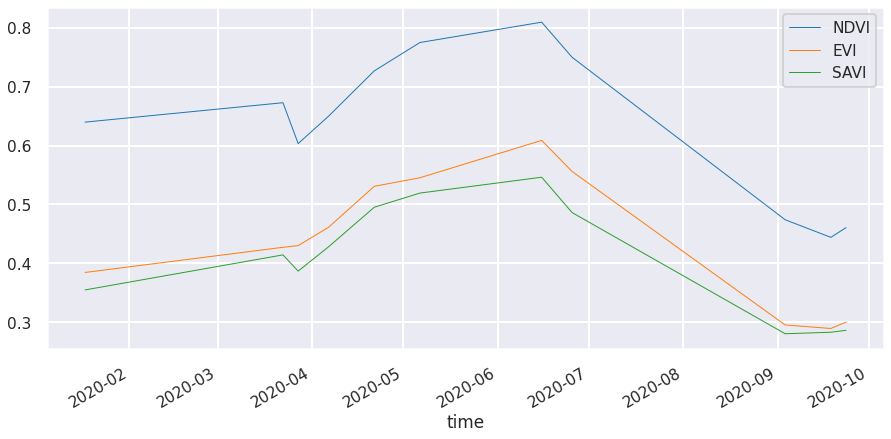

In [85]:
# define figure style
sns.set_style('darkgrid')
sns.set_context("poster", font_scale = .7)

# plot
ax = data_frame.plot(figsize=[15,7], linewidth=1)

## Further Information
For further information about Dask, please have a look at the [Dask webpage](https://docs.dask.org/en/latest/).

## Recommended next steps

To continue working through the notebooks in this beginner's guide, the following notebooks are designed to be worked through in the following order:

1. [Jupyter Notebooks](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/01_jupyter_introduction.ipynb)
2. [eo2cube](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/02_eo2cube_introduction.ipynb)
3. [Loading Data](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/03_data_lookup_and_loading.ipynb)
4. [Xarray I: Data Structure](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/04_xarrayI_data_structure.ipynb)
5. [Xarray II: Index and Statistics](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/05_xarrayII.ipynb)
6. [Plotting data](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/06_plotting_basics.ipynb)
7. [Spatial analysis](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/07_basic_analysis.ipynb)
8. ***Parallel processing with Dask (this notebook)***

The additional notebooks are designed for users to build up both basic and advanced skills which are not covered by the beginner's guide. Self-motivated users can go through them according to their own needs. They act as complements for the guide:
<br>

1. [Python's file management tools](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/I_file_management.ipynb)
2. [Image Processing basics using NumPy and Matplotlib](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/II_numpy_image_processing.ipynb)
3. [Vector Processing](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/III_process_vector_data.ipynb)
4. [Advanced Plotting](https://github.com/eo2cube/eo2cube_notebooks/blob/main/get_started/intro_to_eo2cube/IV_advanced_plotting.ipynb)

***

## Additional information

<font size="2">This notebook for the usage in the Open Data Cube entities of the [Department of Remote Sensing](http://remote-sensing.org/), [University of Wuerzburg](https://www.uni-wuerzburg.de/startseite/), is adapted from [Geoscience Australia](https://github.com/GeoscienceAustralia/dea-notebooks), published using the Apache License, Version 2.0. Thanks!</font>

https://doi.org/10.26186/145234 <br>

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.


**Contact:** If you would like to report an issue with this notebook, you can file one on [Github](https://github.com).

**Last modified:** February 2021